In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
a = tf.placeholder("float")
b = tf.placeholder("float")

y = tf.mul(a,b)

sess = tf.Session()

for i in xrange(4):
    print sess.run(y, feed_dict={a:i, b:3})
    print sess.run(y, feed_dict={a:i, b:6})



0.0
0.0
3.0
6.0
6.0
12.0
9.0
18.0


In [4]:
num_points = 1000
vectors_set = []
for i in xrange(num_points):
    x1 = np.random.normal(0.0, 0.55)
    y1= x1*0.1 + 0.3 + np.random.normal(0.0, 0.03)
    vectors_set.append([x1,y1])
    
x_data = [v[0] for v in vectors_set]
y_data = [v[1] for v in vectors_set]

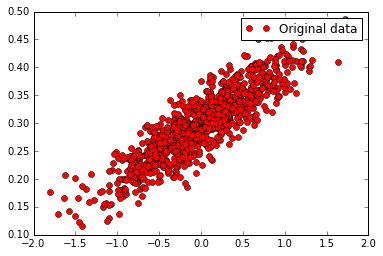

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(x_data, y_data, 'ro', label='Original data')
plt.legend()
plt.show()

In [6]:
W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
b = tf.Variable(tf.zeros([1]))
y = W*x_data + b


In [7]:
loss = tf.reduce_mean(tf.square(y-y_data))


In [8]:
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

In [9]:
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

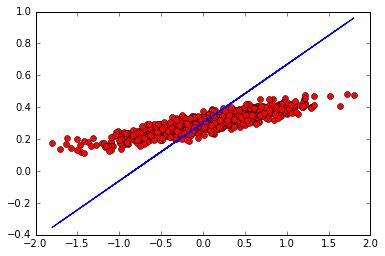

0 [ 0.36449662] [ 0.30293745] 0.0222902


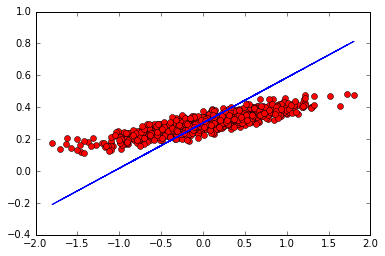

1 [ 0.28393492] [ 0.3015148] 0.0112727


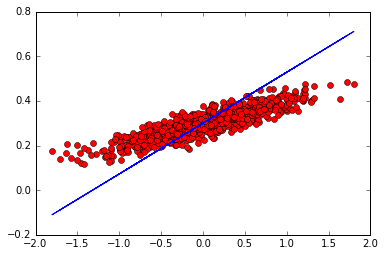

2 [ 0.22778037] [ 0.30056554] 0.00591987


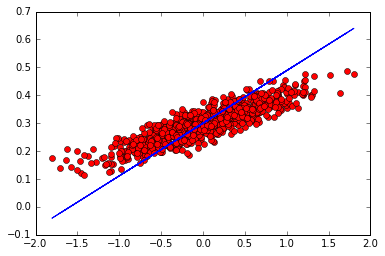

3 [ 0.18863901] [ 0.29990387] 0.0033192


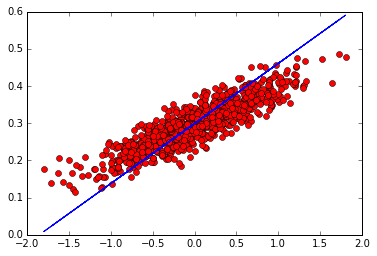

4 [ 0.16135636] [ 0.29944265] 0.00205567


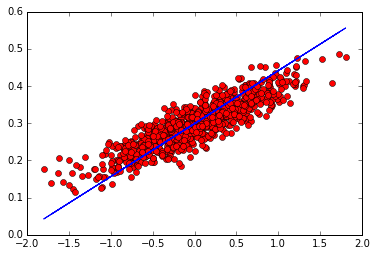

5 [ 0.14233956] [ 0.29912117] 0.00144178


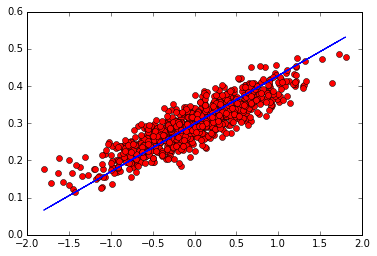

6 [ 0.12908429] [ 0.29889709] 0.00114352


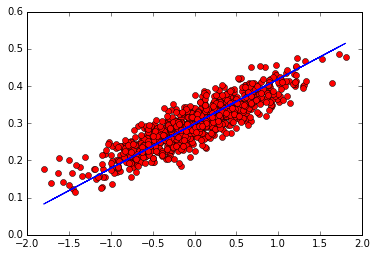

7 [ 0.11984499] [ 0.29874092] 0.000998617


In [10]:
for step in xrange(8):
    sess.run(train)
    plt.plot(x_data, y_data, 'ro')
    plt.plot(x_data, sess.run(W)*x_data + sess.run(b))
    plt.show()
    print step, sess.run(W), sess.run(b), sess.run(loss)

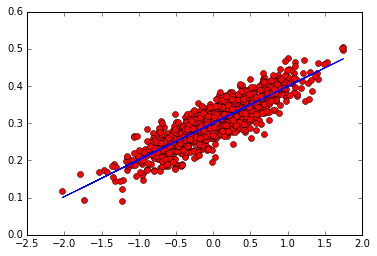

In [23]:
plt.plot(x_data, y_data, 'ro')
plt.plot(x_data, sess.run(W)*x_data + sess.run(b))
plt.show()

##Clustering

In [14]:
num_puntos = 2000
conjunto_puntos = []
for i in xrange(num_puntos):
    if np.random.random() < 0.5:
        conjunto_puntos.append([np.random.normal(0.0, 0.9), np.random.normal(0.0, 0.9)])
    else:
        conjunto_puntos.append([np.random.normal(3.0, 0.5), np.random.normal(1.0, 0.5)])
        

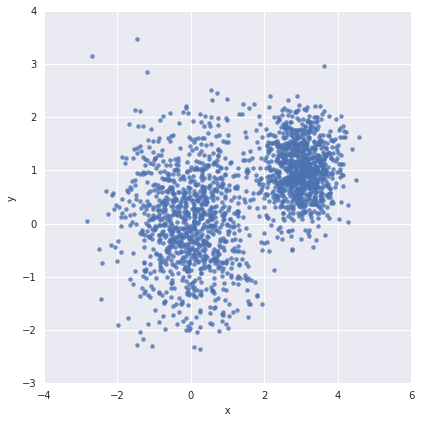

In [15]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({"x": [v[0] for v in conjunto_puntos],
                  "y": [v[1] for v in conjunto_puntos]})

sns.lmplot("x", "y", data = df, fit_reg=False, size = 6)

In [16]:
vectors = tf.constant(conjunto_puntos)
k = 2
centroides = tf.Variable(tf.slice(tf.random_shuffle(vectors),[0,0],[k,-1]))

print vectors.get_shape()
print centroides.get_shape()



(2000, 2)
(2, 2)


In [17]:

expanded_vectors = tf.expand_dims(vectors, 0) 
#above we expanded the dimension along the first dim
expanded_centroides = tf.expand_dims(centroides, 1)
#here we expanded along the 2nd dimension

#since the centroides are a different dimensional tensor from the data
#we need to expand the tensors along on dimension to allow tensorflow to do manipulations of the two

print expanded_vectors.get_shape()
print expanded_centroides.get_shape()


(1, 2000, 2)
(2, 1, 2)


In [18]:
#as we can see the dimensions were not assigned yet

diff = tf.sub(expanded_vectors, expanded_centroides)

In [19]:
#really interesting, it knows to take the difference between 
#each of the four centroides with all of the other tensors

sqr = tf.square(diff)
#now we need to sum the square difference accross each centroid
#the 2 indicates we want to preserve the y and x components (last dimension)
#but otherwise we are minimizing the total sum
distances = tf.reduce_sum(sqr, 2) 
assignments = tf.argmin(distances, 0)
#this gives us the smallest distance centroid for each of the 2000 data points. 


In [20]:

#simplified version of code, comment out to run

#assignments = tf.argmin(tf.reduce_sum(tf.square(tf.sub(expanded_vectors, expanded_centroides)), 2), 0)

means = tf.concat(0, 
                  [tf.reduce_mean(
            tf.gather(
                vectors, tf.reshape(
                    tf.where( 
                        tf.equal(assignments, c)),[1,-1])),
            reduction_indices=[1]) for c in xrange(k)])

update_centroides = tf.assign(centroides, means)

init_op = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init_op)


In [23]:

for step in xrange(100):
   _, centroid_values, assignment_values = sess.run([centroides, update_centroides, assignments])

In [24]:
print sess.run([update_centroides, centroides, assignments])

[array([[ 2.93992424,  1.03172123],
       [-0.08464243,  0.01423642]], dtype=float32), array([[ 2.93992424,  1.03172123],
       [-0.08464243,  0.01423642]], dtype=float32), array([0, 1, 1, ..., 0, 1, 1])]


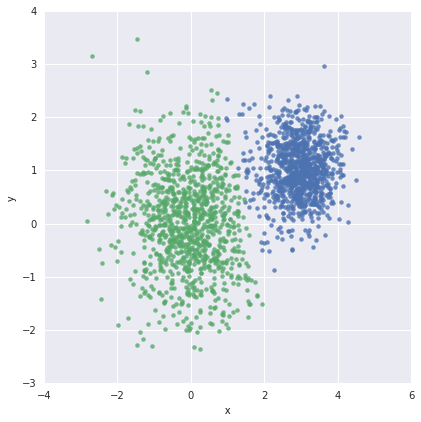

In [25]:
data = {"x": [], "y": [], "cluster": []}

for i in xrange(len(assignment_values)):
  data["x"].append(conjunto_puntos[i][0])
  data["y"].append(conjunto_puntos[i][1])
  data["cluster"].append(assignment_values[i])

df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, fit_reg=False, size=6, hue="cluster", legend=False)
plt.show()

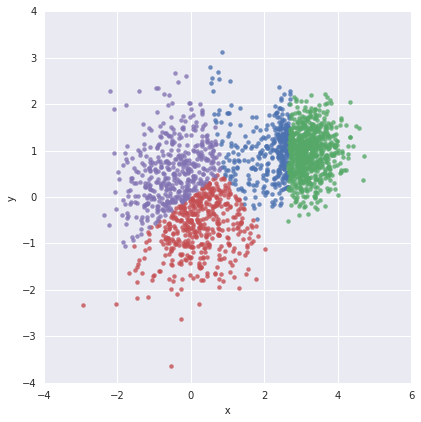

In [104]:
#let's try it with 4 centroides
vectors = tf.constant(conjunto_puntos)
k = 4
centroides = tf.Variable(tf.slice(tf.random_shuffle(vectors),[0,0],[k,-1]))

expanded_vectors = tf.expand_dims(vectors, 0) 
expanded_centroides = tf.expand_dims(centroides, 1)

assignments = tf.argmin(tf.reduce_sum(tf.square(tf.sub(expanded_vectors, expanded_centroides)), 2), 0)

means = tf.concat(0, 
                  [tf.reduce_mean(
            tf.gather(
                vectors, tf.reshape(
                    tf.where( 
                        tf.equal(assignments, c)),[1,-1])),
            reduction_indices=[1]) for c in xrange(k)])

update_centroides = tf.assign(centroides, means)

init_op = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init_op)

for step in xrange(100):
   _, centroid_values, assignment_values = sess.run([update_centroides, centroides, assignments])
data = {"x": [], "y": [], "cluster": []}

for i in xrange(len(assignment_values)):
  data["x"].append(conjunto_puntos[i][0])
  data["y"].append(conjunto_puntos[i][1])
  data["cluster"].append(assignment_values[i])

df = pd.DataFrame(data)
sns.lmplot("x", "y", data=df, fit_reg=False, size=6, hue="cluster", legend=False)
plt.show()


In [1]:
#Mnist

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [107]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

x = tf.placeholder("float", [None, 784]) #where None indicates
#it can be any size, it is the size of our data vector

y = tf.nn.softmax(tf.matmul(x, W)+b)

In [108]:
y_ = tf.placeholder("float", [None, 10])
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
#the above calculates the cross entropy between the correct y and the calculated y

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
sess = tf.Session()

sess.run(tf.initialize_all_variables())


#this is batch gradient descent
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x:batch_xs, y_: batch_ys})

In [109]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [110]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [111]:
print sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})

0.9141


In [112]:
#Now with Convolutional Neural Networks

In [122]:
x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

x_image = tf.reshape(x, [-1,28,28,1])
print "x_image="
print x_image

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess = tf.Session()

sess.run(tf.initialize_all_variables())

for i in range(200):
   batch = mnist.train.next_batch(50)
   if i%10 == 0:
     train_accuracy = sess.run( accuracy, feed_dict={ x:batch[0], y_: batch[1], keep_prob: 1.0})
     print("step %d, training accuracy %g"%(i, train_accuracy))
   sess.run(train_step,feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"% sess.run(accuracy, feed_dict={ 
       x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

x_image=
Tensor("Reshape_39:0", shape=(?, 28, 28, 1), dtype=float32)
step 0, training accuracy 0.12
step 10, training accuracy 0.48
step 20, training accuracy 0.82
step 30, training accuracy 0.98
step 40, training accuracy 0.88
step 50, training accuracy 0.88
step 60, training accuracy 0.96
step 70, training accuracy 0.92
step 80, training accuracy 0.92
step 90, training accuracy 0.94
step 100, training accuracy 0.94
step 110, training accuracy 0.94
step 120, training accuracy 0.92
step 130, training accuracy 0.96
step 140, training accuracy 0.84
step 150, training accuracy 0.88
step 160, training accuracy 0.96
step 170, training accuracy 0.98
step 180, training accuracy 0.96
step 190, training accuracy 0.94
test accuracy 0.9574


In [119]:
?tf.train.AdamOptimizer